*[Notebook is based on the code from the chapter 2 of the book](https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb)*  
Text from the book is omitted in this notebook. Please the link ☝ to read the book's content.

In [1]:
import os
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
# Path for the rood dir with images of bears
# Should have this format %bear_cat%/*.jpg
dataset_path = Path("../models/chapter2/bears/data").absolute()

# Function for getting paths for all `.jpg` files in the `root_path` recursively
def get_images(root_path: Path) -> Path:
    return get_files(path=root_path, extensions={".jpg"}, recurse=True)

fns = get_images(dataset_path)
failed = verify_images(fns)
failed

(#0) []

Examples of preprocessing images to make them of equal size.

Cropping - `Resize(128)`

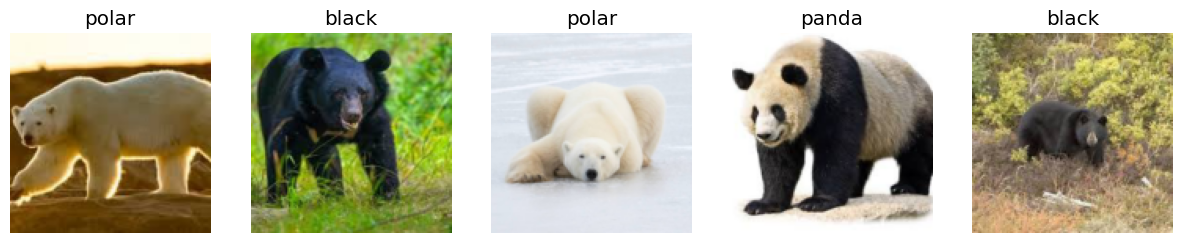

In [4]:
bears_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_images, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

bears_data_block.dataloaders(dataset_path).valid.show_batch(max_n=5, nrows=1)

Squishing - `Resize(128, ResizeMethod.Squish)`

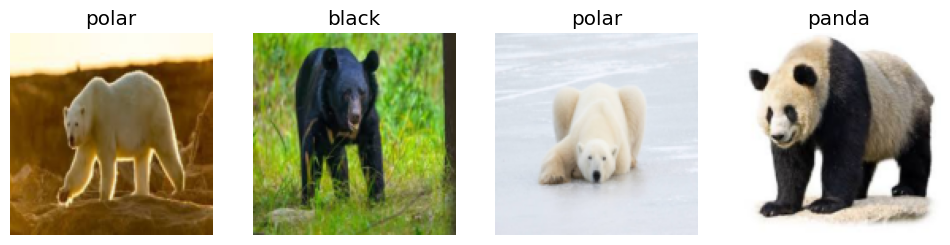

In [7]:
squished_bears = bears_data_block.new(item_tfms=Resize(128, ResizeMethod.Squish))
squished_bears.dataloaders(dataset_path).valid.show_batch(max_n=4, nrows=1)

Padding with black pixels - `Resize(128, ResizeMethod.Pad, pad_mode='zeros')`

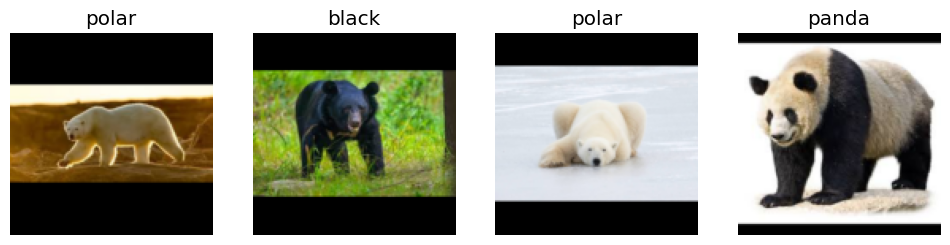

In [8]:
resized_bears = bears_data_block.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
resized_bears.dataloaders(dataset_path).valid.show_batch(max_n=4, nrows=1)

Check the book to get more info about downsides of these resizing approaches from above ☝

Random cropping - `RandomResizedCrop(128, min_scale=0.3)`

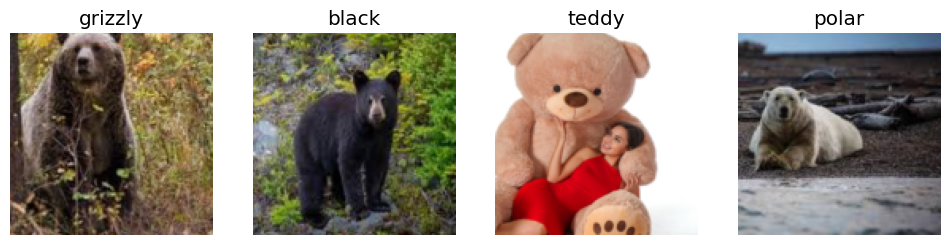

In [11]:
rng_cropped_bears = bears_data_block.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
rng_cropped_bears.dataloaders(dataset_path).train.show_batch(max_n=4, nrows=1)

Augmentation - `bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))`

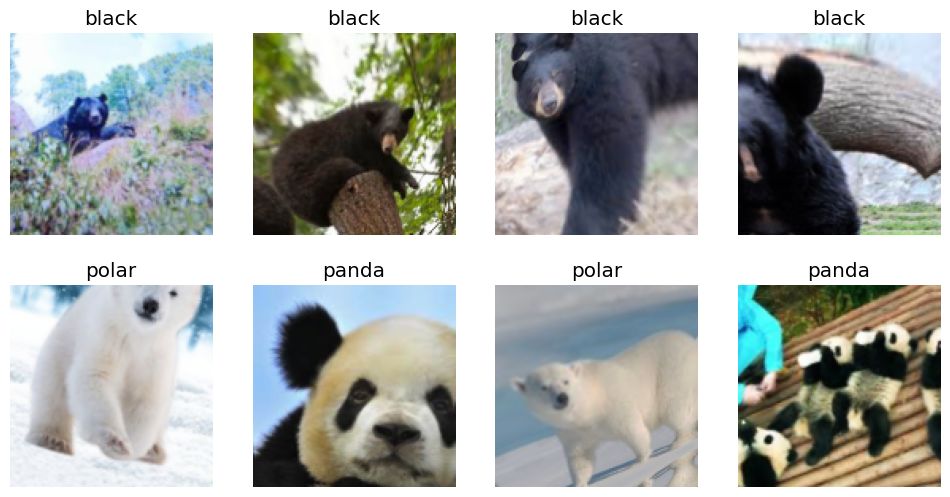

In [13]:
augmented_bears = bears_data_block.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
augmented_bears.dataloaders(dataset_path).train.show_batch(max_n=8, nrows=2)

Training of the model

In [14]:
train_data = bears_data_block.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = train_data.dataloaders(dataset_path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.361557,1.565683,0.573770,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.734688,0.679325,0.163934,00:06
1,0.613753,0.307563,0.114754,00:06
2,0.440785,0.186304,0.081967,00:06
3,0.354538,0.137651,0.065574,00:06


Confusion matrix

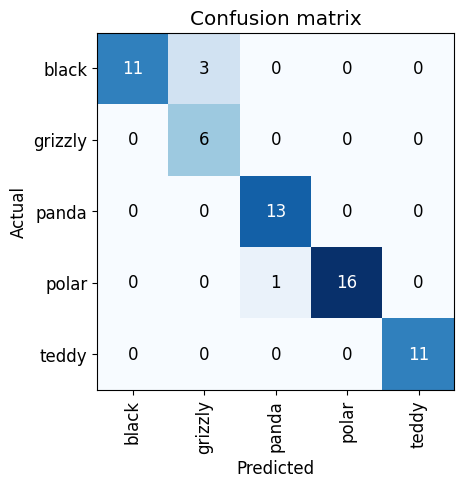

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Visualize top losses

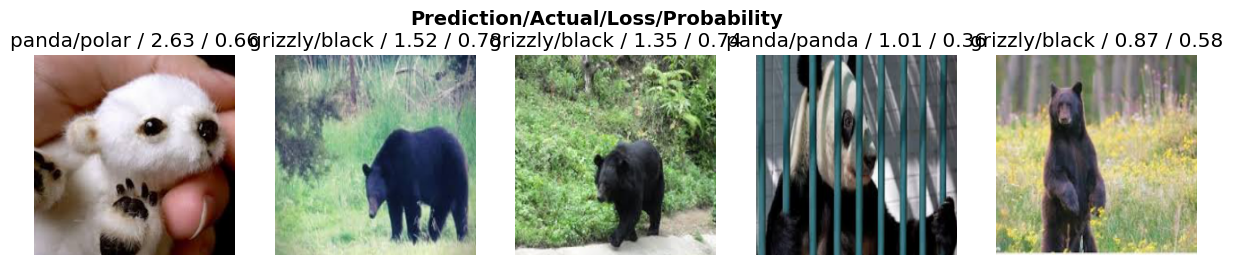

In [16]:
interp.plot_top_losses(5, nrows=1)

GUI for data cleaning

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Cleaning and relabelling data based on `cleaner`

In [21]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), dataset_path/cat)

Export the model


In [23]:
# Path for a file where to save a trained model for bear classification
bear_cl_model_path = "../models/chapter2/bear_classification.pkl"

learn.export(bear_cl_model_path)

Loading a trained model

In [24]:
learn_inf = load_learner(bear_cl_model_path)

Use the loaded model for prediction

In [29]:
black_example = dataset_path/"black"/"black1.jpg"
grizzly_example = dataset_path/"grizzly"/"grizzly1.jpg"
panda_example = dataset_path/"panda"/"panda1.jpg"
polar_example = dataset_path/"polar"/"polar_bear1.jpg"
teddy_example = dataset_path/"teddy"/"teddy_bear1.jpg"

print(learn_inf.predict(black_example))
print(learn_inf.predict(grizzly_example))
print(learn_inf.predict(panda_example))
print(learn_inf.predict(polar_example))
print(learn_inf.predict(teddy_example))

('black', tensor(0), tensor([9.9578e-01, 1.7587e-04, 3.9830e-03, 3.3010e-07, 6.0761e-05]))


('grizzly', tensor(1), tensor([1.5597e-05, 9.9988e-01, 1.7891e-06, 9.5995e-05, 2.3216e-06]))


('panda', tensor(2), tensor([1.3193e-04, 9.8930e-06, 9.9959e-01, 2.7401e-05, 2.4510e-04]))


('polar', tensor(3), tensor([6.5702e-06, 3.3815e-06, 1.2615e-05, 9.9997e-01, 8.1797e-06]))


('teddy', tensor(4), tensor([3.9999e-06, 5.7635e-06, 1.9196e-04, 4.7412e-06, 9.9979e-01]))


Show model's categories

In [30]:
learn_inf.dls.vocab

['black', 'grizzly', 'panda', 'polar', 'teddy']

Using widgets

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [35]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: panda; Probability: 0.9958')

In [36]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [38]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [39]:
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])